# US-Net

## Camus Dataset

### Patients

Lets first analyze dataset by reading Info files

In [50]:
from os import path

def read_info(patient, view = '2CH'):
    info_file_name = 'Info_'+view+'.cfg'
    info_file_path = path.join(patient, info_file_name)
    
    def remove_newline(line):
        return line[:-1]
    
    def keyvalue_pair(data):
        [key, value_str] = data.split(':')
        value_str = value_str.strip()
        return [key, value_str]
    
    with open(info_file_path, 'r') as file:
        patient_data = dict()
        info_string = file.readlines()
        info_string = list(map(remove_newline, info_string))
        info = list(map(keyvalue_pair, info_string))
        patient_data.update({'ed':float(info[0][1])})
        patient_data.update({'es':float(info[1][1])})
        patient_data.update({'nframe':int(info[2][1])})
        patient_data.update({'sex':info[3][1]})
        patient_data.update({'age':int(info[4][1])})
        patient_data.update({'image_quality':info[5][1]})
        patient_data.update({'lvedv':float(info[6][1])})
        patient_data.update({'lvesv':float(info[7][1])})
        patient_data.update({'lvef':float(info[8][1])})
        patient_data.update({'view':view})
        
        
    return patient_data

{'ed': 1.0,
 'es': 18.0,
 'nframe': 18,
 'sex': 'F',
 'age': 56,
 'image_quality': 'Good',
 'lvedv': 94.0,
 'lvesv': 34.6,
 'lvef': 63.2,
 'view': '2CH'}

In [51]:
from glob import glob
import pandas as pd

patients = glob(r'D:\Ultrasound Data\training\*')

patient_db = list()
for patient in patients:
    patient_data = read_info(patient)
    patient_db.append(patient_data)
    patient_data = read_info(patient, view='4CH')
    patient_db.append(patient_data)
    
patient_db = pd.DataFrame(patient_db)
patient_db

,ed,es,nframe,sex,age,image_quality,lvedv,lvesv,lvef,view
0,1.0,18.0,18,F,56,Good,94.0,34.6,63.2,2CH
1,1.0,20.0,20,F,56,Good,94.0,34.6,63.2,4CH
2,1.0,17.0,17,M,55,Medium,119.1,60.3,49.4,2CH
3,1.0,15.0,15,M,55,Medium,119.1,60.3,49.4,4CH
4,1.0,17.0,17,F,36,Good,105.7,47.1,55.4,2CH
...,...,...,...,...,...,...,...,...,...,...
895,1.0,18.0,18,F,57,Good,78.5,30.6,61.0,4CH
896,1.0,19.0,19,M,84,Poor,55.3,23.3,57.8,2CH
897,1.0,16.0,16,M,84,Medium,55.3,23.3,57.8,4CH
898,1.0,15.0,15,M,72,Good,126.1,76.5,39.4,2CH


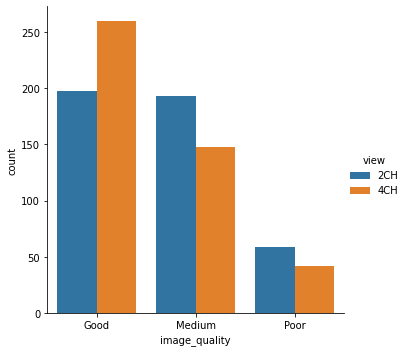

In [52]:
import seaborn as sns

sns.catplot(data=patient_db, x='image_quality', kind='count', hue='view')

## Prepare the data

## Load data

In [3]:
import tensorflow as tf
import tensorflow_io as tfio
from params import params

import matplotlib.pyplot as plt

import cv2

training_params = params.Params()
print(training_params)

Params(dataset_path='D:\\Ultrasound Data\\training', views='both')


In [4]:
from glob import glob
from os import path


DATASET_PATH = r'D:\Ultrasound Data\training'


def isimage(fileaddress):
    filename = path.basename(fileaddress).split('.')[0]
    if filename.endswith('gt') or filename.endswith('sequence'):
        return False
    else:
        return True

def is2ch_view(fileaddress):
    filename = path.basename(fileaddress)
    view = filename.split('_')[1]
    if view=='2CH':
        return True
    else:
        return False

def issequence(fileaddress):
    filename = path.basename(fileaddress).split('.')[0]
    if filename.endswith('sequence'):
        return True

path_structure = path.join(training_params.dataset_path, r'*\*.raw')
all_file_paths = glob(path_structure)

images = list(filter(isimage, all_file_paths))
sequnces = list(filter(issequence, all_file_paths))

Now that we have our image files in place, let's make our dataset:

In [11]:
@tf.function
def read_raw_image(image_path):
    imgfile = tf.io.read_file(image_path)
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    print()
    img = tf.reshape(imgbytes, (778, 549))
    img = tf.cast(img, tf.float32)
    return img


@tf.function
def read_mhd_data(mhd_address):
    file_metadata_string = tf.io.read_file(mhd_address)
    print(file_metadata_string)
    # Complete this function later
    
@tf.function
def read_image_and_mask(input_address):
    image = read_raw_image(input_address)
    mask_fileadd = tf.strings.split(input_address, '.')[0]
    mask_fileadd = tf.strings.join([mask_fileadd, '_gt.raw'])
    mask_fileadd = tf.squeeze(mask_fileadd)
    mask = read_raw_image(mask_fileadd)
    return (image, mask)

@tf.function
def read_mhd_data(mhd_address)

inputfiles = tf.data.Dataset.from_tensor_slices(images)
train_ds = inputfiles.map(read_image_and_mask)

train_ds

<MapDataset shapes: ((778, 549), (778, 549)), types: (tf.float32, tf.float32)>

Now let's take a look on some of our examples:

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plot_counter = 0

for something in images:
    read_image_and_mask(something)

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Input to reshape is a tensor with 872916 values, but the requested shape has 427122
	 [[{{node PartitionedCall/Reshape}}]]
	 [[StringSplit/RaggedGetItem/strided_slice_4/stack/_22]]
  (1) Invalid argument:  Input to reshape is a tensor with 872916 values, but the requested shape has 427122
	 [[{{node PartitionedCall/Reshape}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_read_image_and_mask_1536]

Function call stack:
read_image_and_mask -> read_image_and_mask


<Figure size 432x288 with 0 Axes>

In [24]:
x = train_ds.take(4)

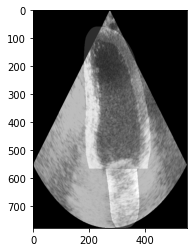

In [11]:
import time




def read_raw_seq(image_path):
    imgfile = tf.io.read_file(image_path)
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, (-1, 778, 549))
    return img


def play_sequence(sequence_array):
    cap = cv2.VideoCapture()
    has_frames = True
    frame_counter = 0
    while True:
        frame = sequence_array[frame_counter, :, :]
        cv2.imshow('frame',frame)
        time.sleep(0.1)
        frame_counter+=1
        if frame_counter==sequence_array.shape[0]:
            frame_counter = 0
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
    
img = read_raw_image(r'patient0001/patient0001_2CH_ED.raw')
mask = read_raw_image(r'patient0001/patient0001_2CH_ED_gt.raw')
plt.imshow(1*img + 30*mask, 'gray')
#play_sequence(seq.numpy())


### Read Sequence

In [6]:
seq = read_raw_seq(r'patient0001/patient0001_4CH_sequence.raw')
play_sequence(seq.numpy())

Now that we know how to read images and masks, we will process their addresses, and then use tf.data to build the input pipeline. First, we must find the file addresses:

Now we should convert these file addresses to tensorflow datasets